## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## 1. Data Exploration & Extracting HOG Features

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2004
4.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  0.  0.  1.  0.  1.]
0.03767 Seconds to predict 10 labels with SVC


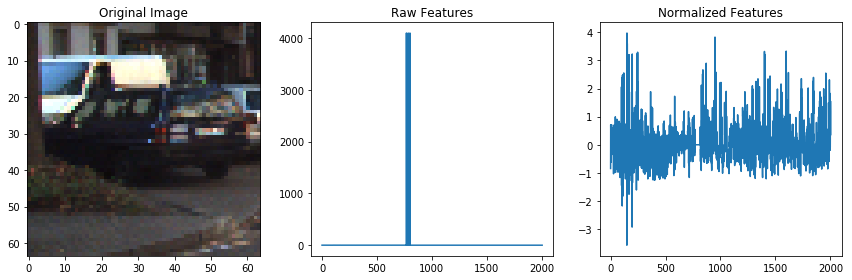

In [19]:
import numpy as np
import cv2
import glob
import pickle
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


def read_dataset():
    # Make a list of Vehicle & Non Vehicle images
    car_images1 = glob.glob('./vehicles/GTI_Far/*.png')
    car_images2 = glob.glob('./vehicles/GTI_Left/*.png')
    car_images3 = glob.glob('./vehicles/GTI_MiddleClose/*.png')
    car_images4 = glob.glob('./vehicles/GTI_Right/*.png')
    car_images5 = glob.glob('./vehicles/KITTI_extracted/*.png')

    notcar_images1 = glob.glob('./non-vehicles/Extras/*.png')
    notcar_images2 = glob.glob('./non-vehicles/GTI/*.png')

    cars = []
    notcars = []

    for image1 in car_images1:
        cars.append(image1)

    for image2 in car_images2:
        cars.append(image2)

    for image3 in car_images3:
        cars.append(image3)

    for image4 in car_images4:
        cars.append(image4)

    for image5 in car_images5:
        cars.append(image5)    

    for image6 in notcar_images1:
        notcars.append(image6)

    for image7 in notcar_images2:
        notcars.append(image7) 
    
    return cars, notcars

def data_look(car_list, notcar_list):
    
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict


def plot_car(cars, notcars):
    #cars, notcars = read_dataset()
    data_info = data_look(cars, notcars)

    print('Your function returned a count of', 
          data_info["n_cars"], ' cars and', 
          data_info["n_notcars"], ' non-cars')
    print('of size: ',data_info["image_shape"], ' and data type:', 
          data_info["data_type"])
    # Just for fun choose random car / not-car indices and plot example images   
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])


    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

def plot_hog(cars, notcars):    
    #cars, notcars = read_dataset()
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL"
    
    for x in range(0,3):
    
        # Generate a random index to look at a car image
        ind = np.random.randint(0, len(cars))
        # Read in the image
        image_car = mpimg.imread(cars[ind])
        gray_car = cv2.cvtColor(image_car, cv2.COLOR_RGB2GRAY)
        
        image_notcar = mpimg.imread(notcars[ind])
        gray_notcar = cv2.cvtColor(image_notcar, cv2.COLOR_RGB2GRAY)
        
        # Call our function with vis=True to see an image output
        features_car, hog_image_car = get_hog_features(gray_car, orient, 
                                pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=False)
        
        features_notcar, hog_image_notcar = get_hog_features(gray_notcar, orient, 
                                pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=False)
        
        # Plot the examples
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(image_car, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(hog_image_car, cmap='gray')
        plt.title('Car HOG Visualization')
        
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(image_notcar, cmap='gray')
        plt.title('Example Non-car Visualization')
        plt.subplot(122)
        plt.imshow(hog_image_notcar, cmap='gray')
        plt.title('Non-Car HOG Visualization')        
        x = x+1



# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
"""
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)    
        else: feature_image = np.copy(image)      
        
        # Apply bin_spatial() to get spatial color features
        #spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        #hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        #features.append(np.concatenate((spatial_features, hist_features)))
              
         # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
    # Return list of feature vectors
    return features
"""
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img



def combine_normalize(cars, notcars):
    
    cs= 'YCrCb'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()
    
    car_features = extract_features(cars, color_space=cs, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=cs, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        car_ind = np.random.randint(0, len(cars))
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(cars[car_ind]))
        plt.title('Original Image')
        plt.subplot(132)
        plt.plot(X[car_ind])
        plt.title('Raw Features')
        plt.subplot(133)
        plt.plot(scaled_X[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
    else: 
        print('Your function only returns empty feature vectors...')
    
    # Preparing Labels, and split for Training and Test data
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    
    return    

    
cars, notcars = read_dataset()
#plot_car(cars,notcars)    
#plot_hog(cars,notcars)
combine_normalize(cars, notcars)



## 2. Pipeline (test images)

#### 1. Provide example of a distortion-corrected image

The horizon and landscape on the undistorted image shows a change.

#### 2. Binary Image Result

#### 3. Perspective Transform Image Result

#### 4. Identify Lane Line Pixels

#### 5. Identify Radius of Curvature & Vehicle Position

#### 6. Pipeline for Test Images

In [ ]:
# Intial Pipeline
def pipeline(img, ksize):
    
    #Run this Pipeline to test all methods
            
    # Undistort image
    undistorted_test = cal_undistort(img, objpoints, imgpoints)
    
    # Sobel Operator (X or Y Gradient)    
    gradx = abs_sobel_thresh(undistorted_test, orient='x', sobel_kernel=ksize, thresh=(15, 255))
    grady = abs_sobel_thresh(undistorted_test, orient='y', sobel_kernel=ksize, thresh=(30, 255))

    # Sobel Magnitude of Gradient
    mag_binary = mag_thresh(undistorted_test, sobel_kernel=ksize, mag_thresh=(40, 255))
    
    # Sobel Direction of Gradient
    dir_binary = dir_threshold(undistorted_test, sobel_kernel=ksize, thresh=(0, 0.09))

    # HLS Color Channel S - Channel
    s_channel = hls_s(undistorted_test, thresh=(120, 255))
    
    # HLS Color Channel S - Channel
    l_channel = hls_l(undistorted_test, thresh=(210, 255))
    
    # Combine X,Y,Mag gradient, and S - Channel
    combined = np.zeros_like(l_channel)
    combined[(s_channel == 1) | (l_channel == 1)] = 1
    
    # Area of Interest Mask
    area_img = region_of_interest(combined)
    
    # Perspective Transform
    binary_warped, perspective_M, M_inv = corners_unwarp(area_img)
    
    fig, axs = plt.subplots(3,3, figsize=(16, 12))
    fig.subplots_adjust(hspace = .4, wspace=.001)
    axs = axs.ravel()
    axs[0].imshow(undistorted_test)
    axs[0].set_title('Undistorted Image', fontsize=20)
    axs[1].imshow(gradx, cmap='gray')
    axs[1].set_title('Gradient X', fontsize=20)
    axs[2].imshow(grady, cmap='gray')
    axs[2].set_title('Gradient Y', fontsize=20)
    axs[3].imshow(mag_binary, cmap='gray')
    axs[3].set_title('Sobel Magnitude', fontsize=20)
    axs[4].imshow(dir_binary, cmap='gray')
    axs[4].set_title('Sobel Directional', fontsize=20)
    axs[5].imshow(s_channel, cmap='gray')
    axs[5].set_title('HLS S-Channel', fontsize=20)
    axs[6].imshow(l_channel, cmap='gray')
    axs[6].set_title('HLS L-channel', fontsize=20)
    axs[7].imshow(combined, cmap='gray')
    axs[7].set_title('Combined Image', fontsize=20)
    axs[8].imshow(binary_warped, cmap='gray')
    axs[8].set_title('Perspective Transform', fontsize=20)
    
# Demo All Functions
ksize=5 # Setting Kernel Size
test_image = cv2.imread('./test_images/test3.jpg')
pipeline(test_image, ksize)


## 3. Pipeline Video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def video_process(img):
    global i, ploty_p, left_fitx_p, right_fitx_p, leftx_p, rightx_p, lefty_p, righty_p, hist_p
    global ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi
    img_t = img
    offset = 100
    undist, bin_img, M, M_inverse = pipeline2(img_t, ksize)    
    #Plot the Result
    ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist = slidingwindow(bin_img)
    left_curverad, right_curverad = radius_curv(bin_img, ploty, leftx, rightx, lefty, righty)
    pos_off = dist_from_center(hist)
    
    if int((left_curverad + right_curverad)/2) > 900:
        ploty_p, left_fitx_p, right_fitx_p, leftx_p, rightx_p, lefty_p, righty_p, hist_p = ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist
        lane_img = draw_lines(undist, bin_img, ploty, left_fitx, right_fitx, M_inverse)
        result = write_details(undist, lane_img, pos_off, (left_curverad + right_curverad)/2) 
        i = i+1
        if (i-offset == 100):
            ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi = ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist
    elif int((left_curverad + right_curverad)/2) < 900:
        ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist = ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi
        lane_img = draw_lines(undist, bin_img, ploty, left_fitx, right_fitx, M_inverse)
        result = write_details(undist, lane_img, pos_off, (left_curverad + right_curverad)/2) 

    return result    


    

In [ ]:
yellow_output = 'yellow_latest_version_9.mp4'
clip2 = VideoFileClip('project_video.mp4', audio=False)
yellow_clip = clip2.fl_image(video_process)
%time yellow_clip.write_videofile(yellow_output, audio=False)